In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# load data
df = pickle.load(open('data/abc_classification_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# class balance (proportion of 1s and 0s we're predicting for)
df['signup_flag'].value_counts(normalize = True) # normalize outputs the percentages

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [6]:
# deal with missing value
print(df.isna().sum()) # count of na values
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64


In [7]:
# split input and output variables
X = df.drop(['signup_flag'], axis = 1) # input vairables
y = df['signup_flag'] # output variable

In [8]:
# split data into training and test sets
# stratify to ensure same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y) 

In [9]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

In [10]:
# finding best value for max_depth (maximum number of splits)
max_depth_range = list(range(1, 16))
accuracy_scores_f1 = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_f1 = f1_score(y_test, y_pred)
    accuracy_scores_f1.append(accuracy_f1)

accuracy_scores_f1

# display dictionary of accuracy score for each tested depth
accuracy_scores_f1_dict = {}
range_index = 1

for score in accuracy_scores_f1:
    accuracy_scores_f1_dict.update({
        f'Depth {range_index}': round(score, 4)
    })

    range_index += 1

accuracy_scores_f1_dict

{'Depth 1': 0.7042,
 'Depth 2': 0.8511,
 'Depth 3': 0.9027,
 'Depth 4': 0.8932,
 'Depth 5': 0.9358,
 'Depth 6': 0.9159,
 'Depth 7': 0.9434,
 'Depth 8': 0.9434,
 'Depth 9': 0.9245,
 'Depth 10': 0.9434,
 'Depth 11': 0.9346,
 'Depth 12': 0.9259,
 'Depth 13': 0.9159,
 'Depth 14': 0.9245,
 'Depth 15': 0.9259}

In [11]:
# determine max accuracy and optimal depth
max_accuracy = max(accuracy_scores_f1)
max_accuracy_idx = accuracy_scores_f1.index(max_accuracy)
optimal_depth = max_depth_range[max_accuracy_idx]

print(f'The Optimal Depth is: {optimal_depth}')

The Optimal Depth is: 7


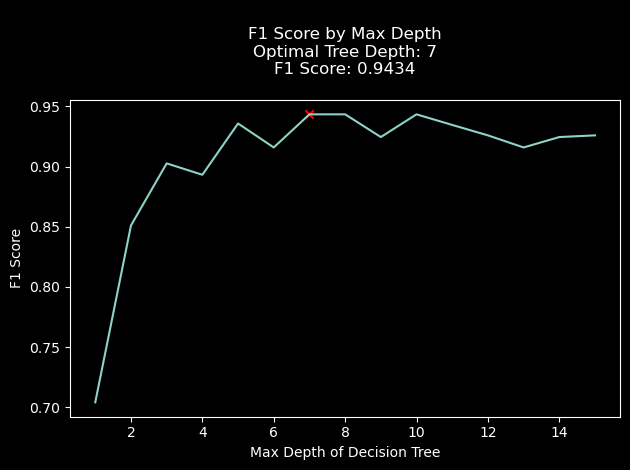

In [12]:
# plot of max depths
plt.plot(max_depth_range, accuracy_scores_f1)
plt.scatter(optimal_depth, max_accuracy, marker = 'x', color = 'red')

plt.title(f'''
F1 Score by Max Depth
Optimal Tree Depth: {optimal_depth}
F1 Score: {round(max_accuracy, 4)}
''')

plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [13]:
# train model
clf = DecisionTreeClassifier(max_depth = optimal_depth)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [14]:
# assess model accuracy
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [15]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[113   5]
 [  3  49]]


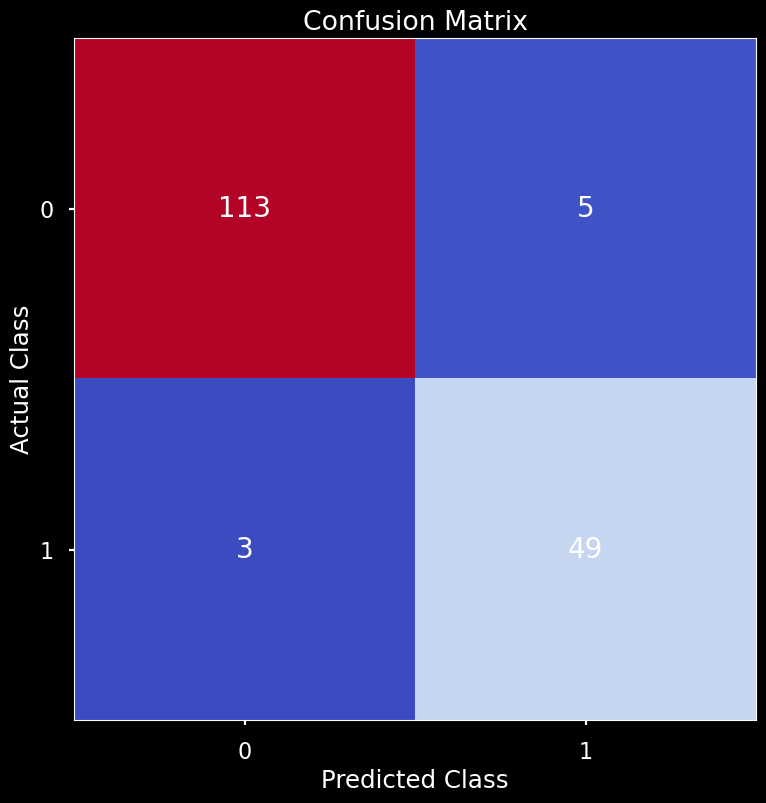

In [16]:
# plot confusion matrix
plt.style.use('seaborn-poster')
plt.matshow(conf_matrix, cmap = 'coolwarm')
plt.gca().xaxis.tick_bottom()
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = 'center', va = 'center', fontsize = 20)

plt.show()

In [17]:
# accuracy score (number of correct classification out of all attempted classifications)
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.9529411764705882


In [18]:
# precision score (of all observations predicted positive, how many were actually positive)
precision = precision_score(y_test, y_pred_class)
print(f'Precision Score: {precision}')

Precision Score: 0.9074074074074074


In [19]:
# recall score (of all positive observations, how many were predicted as positive)
recall = recall_score(y_test, y_pred_class)
print(f'Recall Score: {recall}')

Recall Score: 0.9423076923076923


In [20]:
# F1-Score (harmonic mean of precision and recall) (useful for imbalanced data)
f1 = f1_score(y_test, y_pred_class)
print(f'F1-Score: {f1}')

F1-Score: 0.9245283018867925


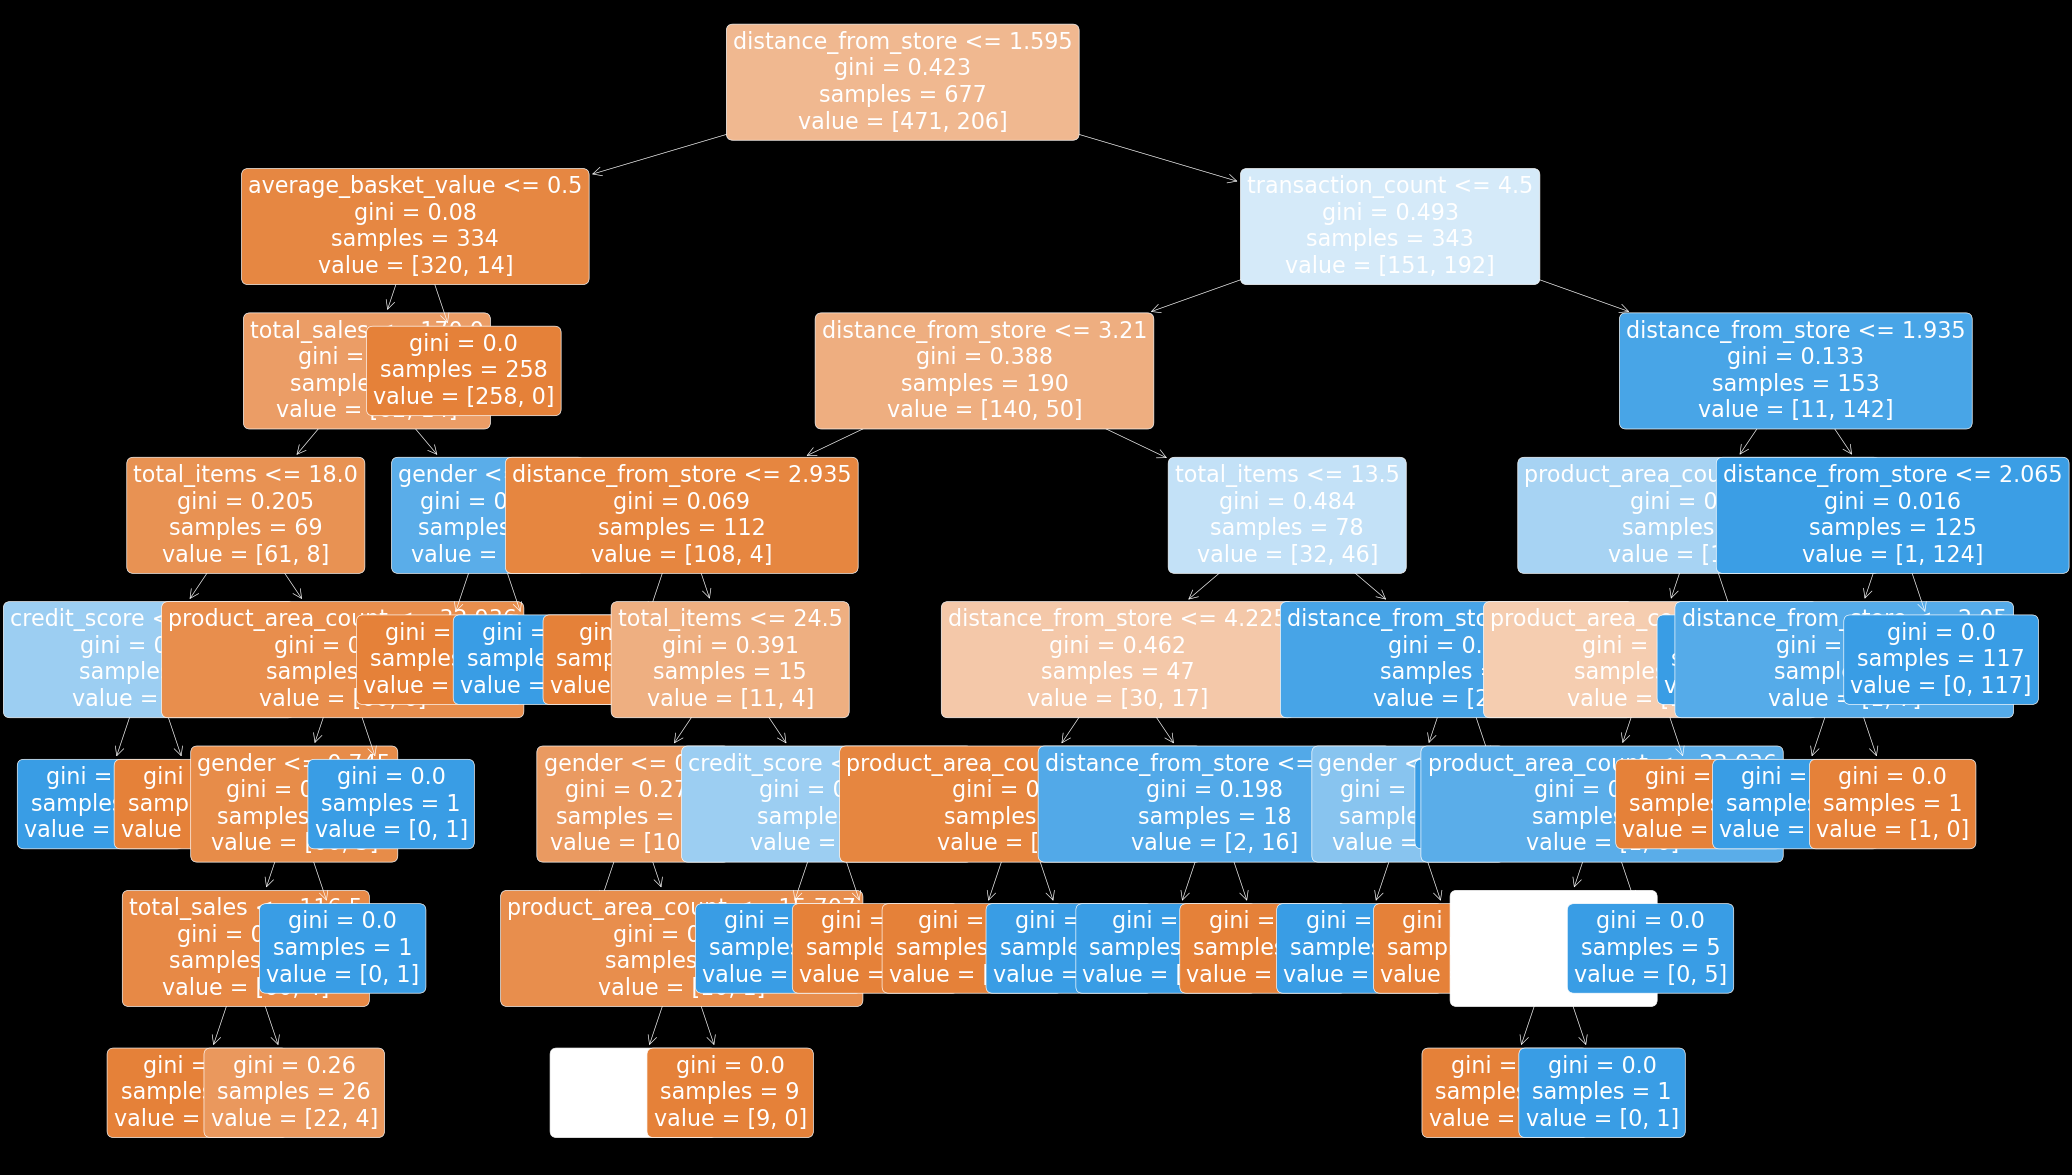

In [21]:
# plot model
plt.figure(figsize = (25, 15))
tree = plot_tree(
    clf,
    feature_names = X.columns,
    filled = True,
    rounded = True,
    fontsize = 16
)